# First approach

A simple unigram model with SVC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import unicodedata
import string
from nltk.stem.snowball import FrenchStemmer


In [2]:
CSV_PATH = Path("../data/raw/comments_train.csv")
MODEL_PATH = Path("../models/sentiment_pipe.joblib")

In [3]:
import dotenv
import os

dotenv.load_dotenv(dotenv.find_dotenv())

True

In [7]:
os.environ.get("TOKEN") == "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9"

True

## Preprocessing

In [39]:
df = pd.read_csv(CSV_PATH)
df.head(5)

,comment,sentiment
0,J'ai réservé ma table quelques mois à l'avance...,Positive
1,Que dire... Nicolas sale est un chef d excepti...,Positive
2,Dans une rue tranquille non loin du Panthéon u...,Positive
3,Rien à redire le restaurant est irréprochablem...,Positive
4,Comme avec les autres commentaires nos repas é...,Positive


In [40]:
# stemmer = FrenchStemmer()
from nltk import stem
stemmer = stem.regexp.RegexpStemmer('s$|es$|era$|erez$|ions$| <etc> ')

import spacy
nlp = spacy.load("fr_core_news_sm")


def clean_text(txt):
    new_txt = ''.join([c.lower() if c not in string.punctuation else ' ' for c in txt])
    new_txt = unicodedata.normalize('NFKD', new_txt).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    new_txt = " ".join([word for word in new_txt.split() if word])
    new_txt = ' '.join([stemmer.stem(word) for word in new_txt.split()])
#     text = nlp(new_txt)
#     text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return new_txt
    
ex = df.comment[0]
clean_text(ex)

'j ai reserve ma table quelqu moi a l avance le service etait impeccable pendant tout le processu nou somm arriv a temp et etaient rapidement assi un personnel tr accueillant attention a tou l detail nou avon eu un verre de champagne tandi que nou avon plu'

In [41]:
df["clean"] = df.comment.apply(clean_text)
df

,comment,sentiment,clean
0,J'ai réservé ma table quelques mois à l'avance...,Positive,j ai reserve ma table quelqu moi a l avance le...
1,Que dire... Nicolas sale est un chef d excepti...,Positive,que dire nicola sale est un chef d exception q...
2,Dans une rue tranquille non loin du Panthéon u...,Positive,dan une rue tranquille non loin du pantheon un...
3,Rien à redire le restaurant est irréprochablem...,Positive,rien a redire le restaurant est irreprochablem...
4,Comme avec les autres commentaires nos repas é...,Positive,comme avec l autr commentair no repa etaient i...
...,...,...,...
1612,Le service a été rapide et les crêpes très bon...,Positive,le service a ete rapide et l crep tr bonn l pa...
1613,Restaurant excellent bon rapport qualité-prix ...,Positive,restaurant excellent bon rapport qualite prix ...
1614,Incroyable mais vrai 190€ la baguette ! Que di...,Negative,incroyable mai vrai 190 la baguette que di je ...
1615,Un japonais assez chic des beaux quartiers. No...,Positive,un japonai assez chic d beaux quartier nou y s...


In [42]:
df = df.drop('comment', axis=1)
df

,sentiment,clean
0,Positive,j ai reserve ma table quelqu moi a l avance le...
1,Positive,que dire nicola sale est un chef d exception q...
2,Positive,dan une rue tranquille non loin du pantheon un...
3,Positive,rien a redire le restaurant est irreprochablem...
4,Positive,comme avec l autr commentair no repa etaient i...
...,...,...
1612,Positive,le service a ete rapide et l crep tr bonn l pa...
1613,Positive,restaurant excellent bon rapport qualite prix ...
1614,Negative,incroyable mai vrai 190 la baguette que di je ...
1615,Positive,un japonai assez chic d beaux quartier nou y s...


In [43]:
" / ".join([str(round(v*100,2)) for v in df.sentiment.value_counts(normalize=True)])

'63.02 / 36.98'

In [44]:
from sklearn.model_selection import train_test_split

X = df.clean.values
y = df.sentiment.apply(lambda x: 0 if x=="Negative" else 1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, stratify=y)

(_, count_train), (_, count_test) = np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)
print(count_train)
print(count_test)

[448 764]
[150 255]


### BOW transformation

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

print(X_train.shape)

vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_trans = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names())

print(X_trans.shape)

NameError: name 'X_train' is not defined

### Model pipeline

In [9]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
clf = make_pipeline(TfidfVectorizer(), SVC(C=1000, gamma='auto'))
clf.fit(X_train, y_train)
print(clf)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('svc', SVC(C=1000, gamma='auto'))])


In [10]:
y_pred = clf.predict(X_test)

<AxesSubplot:>

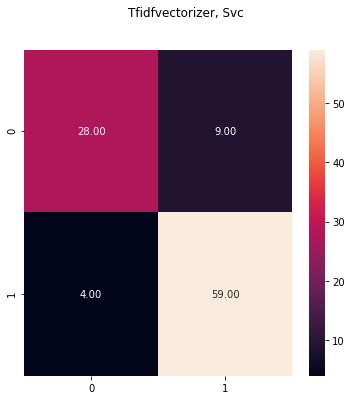

In [11]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle(f"{', '.join([name.title() for name, _ in clf.steps])}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(np.round(100* cm / cm.sum()), annot=True, ax=ax, fmt='.2f')

In [31]:
from sklearn.metrics import SCORERS

print("Available metrics")
print(SCORERS.keys())

print("\nAvailable parameters")
print(make_pipeline(TfidfVectorizer(), SVC()).get_params().keys())

Available metrics
dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samp

In [19]:
cvs = cross_val_score(clf, X_test, y_test, cv=10, scoring='f1')
print(cvs)
print(cvs.mean())

[0.84210526 0.9122807  0.88888889 0.79310345 0.75409836 0.89795918
 0.81632653 0.86206897 0.88       0.87719298]
0.8524024324991866


In [13]:
from sklearn.metrics import classification_report

target_names = ['Negative', 'Positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.88      0.75      0.81       150
    Positive       0.86      0.94      0.90       255

    accuracy                           0.87       405
   macro avg       0.87      0.84      0.85       405
weighted avg       0.87      0.87      0.86       405



In [14]:
from joblib import dump, load
model_path = Path("../models")

dump(clf, model_path / 'tfidf_svm.joblib') 

['..\\models\\tfidf_svm.joblib']

In [43]:
# Grid search 
from sklearn.model_selection import GridSearchCV

parameters = {
    'svc__kernel':('linear', 'rbf'), 
    'svc__C':np.logspace(0, 5, 5),
    'svc__gamma': np.logspace(-6, 0, 6)
}
clf_gs = GridSearchCV(make_pipeline(TfidfVectorizer(), SVC()), parameters, cv=5)
clf_gs.fit(X_train, y_train)

print(clf_gs.best_estimator_)
print(clf_gs.best_params_)
print(clf_gs.best_score_)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('svc', SVC(C=17.78279410038923, gamma=1.0))])
{'svc__C': 17.78279410038923, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}
0.8770635649423527


In [37]:
for i, parap in enumerate(clf.get_params().values()):
    print(i, parap)

0 None
1 [('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC(C=1000, gamma='auto'))]
2 False
3 TfidfVectorizer()
4 SVC(C=1000, gamma='auto')
5 word
6 False
7 strict
8 <class 'numpy.float64'>
9 utf-8
10 content
11 True
12 1.0
13 None
14 1
15 (1, 1)
16 l2
17 None
18 True
19 None
20 None
21 False
22 (?u)\b\w\w+\b
23 None
24 True
25 None
26 1000
27 False
28 200
29 None
30 0.0
31 ovr
32 3
33 auto
34 rbf
35 -1
36 False
37 None
38 True
39 0.001
40 False


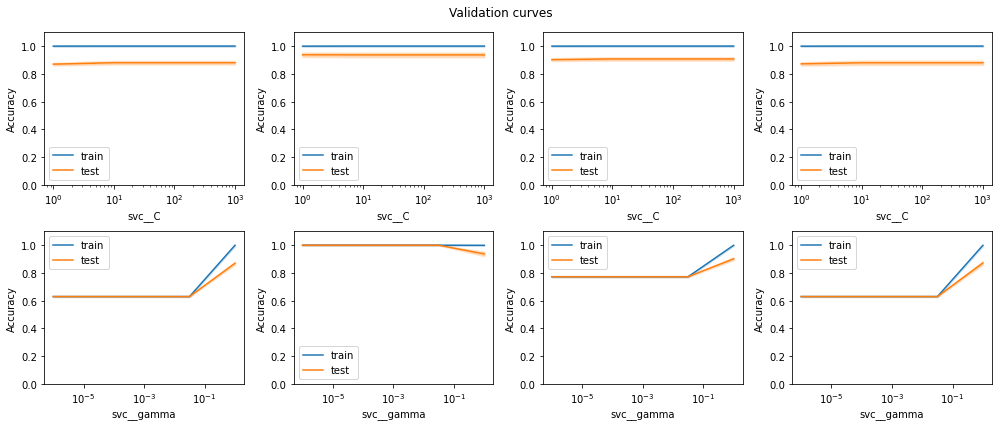

In [41]:
from sklearn.model_selection import validation_curve

scoring_metrics = ["precision", "recall", "f1", "accuracy"]
ncols = len(scoring_metrics)
params = {'svc__C':[1, 10, 100, 1000],'svc__gamma': np.logspace(-6, 0, 5)}
nrows = len(params.keys())

fig, axs = plt.subplots(nrows, ncols, figsize=(14, 6))
fig.suptitle("Validation curves")

for (k, v), axrow in zip(params.items(), axs):
    for score_metric, ax in zip(scoring_metrics, axrow):
        train_scores, test_scores = validation_curve(
            make_pipeline(TfidfVectorizer(), SVC()), X, y, param_name=k, param_range=v,
            scoring=score_metric)

        ax.semilogx(v, train_scores.mean(axis=1), color='tab:blue', label="train")
        ax.fill_between(v, train_scores.mean(axis=1) - train_scores.std(axis=1),
                        train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.2,
                        color='tab:blue', lw=2)
        ax.semilogx(v, test_scores.mean(axis=1), color='tab:orange', label="test")
        ax.fill_between(v, test_scores.mean(axis=1) - test_scores.std(axis=1),
                        test_scores.mean(axis=1) + test_scores.std(axis=1), alpha=0.2,
                        color="tab:orange", lw=2)
        ax.set_xlabel(k)
        ax.set_ylabel(scoring_metric.title())
        ax.set_ylim(0.0, 1.1)
        ax.legend()

plt.tight_layout()
plt.show()

Wan and Gao (2015) applied an ensemble sentiment classification strategy based
on Majority Vote principle of multiple classification methods, including Naïve Bayes,
SVM, Bayesian Network, C4.5 Decision Tree and Random Forest algorithms, for sentiment classification of twitter data for airline services.

Korovkinas, Konstantinas & Danėnas, Paulius & Garšva, Gintautas. (2017). SVM and Naïve Bayes Classification Ensemble Method for Sentiment Analysis. Baltic Journal of Modern Computing. 5. 10.22364/bjmc.2017.5.4.06. 

In [52]:
from sklearn.naive_bayes import MultinomialNB

clf = make_pipeline(TfidfVectorizer(), MultinomialNB())
clf.fit(X_train, y_train)
print(clf)

y_pred = clf.predict(X_test)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])


<AxesSubplot:>

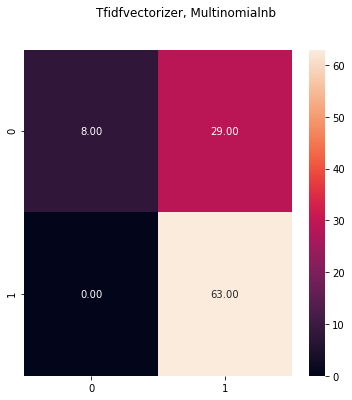

In [53]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle(f"{', '.join([name.title() for name, _ in clf.steps])}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(np.round(100* cm / cm.sum()), annot=True, ax=ax, fmt='.2f')

In [54]:
cvs = cross_val_score(clf, X_test, y_test, cv=10)
print(cvs)
print(cvs.mean())

[0.63414634 0.65853659 0.70731707 0.65853659 0.65853659 0.65
 0.65       0.7        0.625      0.65      ]
0.6592073170731707


In [55]:
from sklearn.metrics import classification_report

target_names = ['Negative', 'Positive']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       1.00      0.22      0.36       150
    Positive       0.69      1.00      0.81       255

    accuracy                           0.71       405
   macro avg       0.84      0.61      0.59       405
weighted avg       0.80      0.71      0.65       405



In [56]:
from joblib import dump, load
model_path = Path("../models")

dump(clf, model_path / 'tfidf_nb.joblib') 

['..\\models\\tfidf_nb.joblib']

In [ ]:
# Grid search 
from sklearn.model_selection import GridSearchCV

parameters = {'svc__kernel':('linear', 'rbf'), 'svc__C':[1, 10, 100, 1000]}
clf_gs = GridSearchCV(make_pipeline(TfidfVectorizer(), SVC()), parameters)
clf_gs.fit(X_train, y_train)


sorted(clf_gs.cv_results_.keys())

In [57]:
clf.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'multinomialnb': MultinomialNB(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tfidfvectorizer__vocab